In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
filename = './starry.jpg'

In [ ]:
import os
print(os.listdir())

['.config', 'starry.jpg', 'sample_data']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


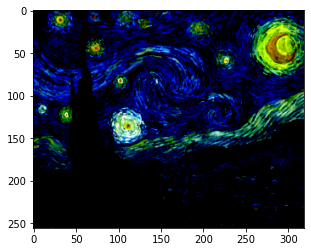

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import skimage.io as skio

input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256), 
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(input_image)
plt.imshow(input_tensor.permute(1, 2, 0))
plt.show()
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [ ]:
def SELoss(x, y):
    """
    Takes in x and y as both tensors. 
    """
    return 0.5 * torch.sum(torch.square(x-y))

loss = SELoss

In [ ]:
def gram(layer):
  F = layer.reshape(layer.shape[0], -1)
  return torch.matmul(F, F.T)

def StyleLoss(x, y):
  N_l2 = x.shape[0]**2
  M_l2 = (x.shape[1] * x.shape[2])**2
  return torch.sum(torch.square(gram(x)-gram(y))) / (4 * N_l2 * M_l2)

loss = StyleLoss

In [ ]:
class FilterResponse:
    "Hook class for saving filter responses at layer x"
    
    def __init__(self):
        self.responses = []
        
    def __call__(self, module, module_in, module_out):
        self.responses.append(module_out)
    
    def clear(self):
        self.responses = []
        
    def __getitem__(self, idx):
        if type(idx) == tuple and len(idx) == 2:
            layer, i = idx
            return torch.squeeze(self.responses[layer])[i]
        elif type(idx) == int:
            return self.responses[idx]
        else:
            raise Exception('idx is either a tuple or a number.')

In [ ]:
ground_truth = FilterResponse()
for layer in model.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        layer.register_forward_hook(ground_truth)

with torch.no_grad():
    output = model(input_batch)

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
def visualize_step(canvas):
    canvas = canvas.detach().cpu().clone()
    canvas = inv_normalize(canvas)
    canvas = torch.clamp(canvas, 0, 1)
    canvas = canvas.permute(1, 2, 0).numpy()
    plt.imshow(canvas)
    plt.show()
    return canvas

In [ ]:
prediction = FilterResponse()
training = models.vgg16(pretrained=True)
training.to('cuda')
for layer in training.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        layer.register_forward_hook(prediction)

In [ ]:
for i in range(64):
  pic = ground_truth[0, i]
  # skio.imshow(pic.cpu().numpy(), cmap='gray')
  # skio.show()

In [ ]:
N = 2
lr = 1
epochs = 10

0 tensor(42.2382, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.2377, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.2187, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.1997, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.1807, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.1617, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.1426, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.1236, device='cuda:0', grad_fn=<MulBackward0>)
2 tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
0 tensor(42.1045, device='cuda:0', grad_fn=<MulBackward0>)
2 ten

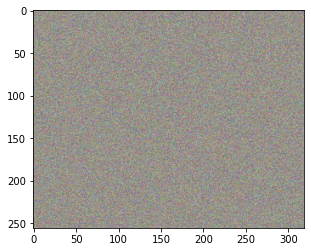

In [ ]:
from torch.optim import LBFGS
def train_LBFGS(input_tensor, N, epochs, lr):
  prediction = FilterResponse()
  model = models.vgg16(pretrained=True)
  model.to('cuda')
  for layer in model.modules():
      if isinstance(layer, torch.nn.modules.conv.Conv2d):
          layer.register_forward_hook(prediction)
  canvas = torch.rand(input_tensor.shape, dtype=torch.float32, requires_grad=True, device='cuda')
  theboos = [0, 2, 4, 7, 10]
  optimizer = LBFGS([canvas], lr=lr)
  coeff = [1e4, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]

  def closure():
    optimizer.zero_grad()
    prediction.clear()
    out = model(canvas.unsqueeze(0))
    error = 0.0
    for i in theboos[:N]:
        err_layer = coeff[i] * loss(ground_truth[i][0], prediction[i][0])
        print(i, err_layer)
        error = error + err_layer
    error /= N
    error.backward()
    return error

  for _ in range(epochs):
    optimizer.step(closure)
  return canvas

test = train_LBFGS(input_tensor, N, epochs, lr)
skio.imsave(str(N)+'-style-layer.jpg', visualize_step(test))

In [ ]:
import sys
print(sys.version)

In [ ]:
from torch.optim import Adam
canvas = torch.rand(input_tensor.shape, dtype=torch.float32, requires_grad=True, device='cuda')
theboos = [0, 2, 4, 7, 10]

epochs = 2000
lr = 0.1
optimizer = Adam([canvas], lr=lr)
for _ in range(epochs):
    optimizer.zero_grad()
    prediction.clear()
    out = training(canvas.unsqueeze(0))
    error = 0.0
    for i in theboos[:N]:
      error = error + loss(ground_truth[i][0], prediction[i][0])
    error = error / N
    if _ % 10 == 0:
      print(_, error)
    error.backward()
    optimizer.step()
skio.imsave(str(N)+'-style-layer-adam.jpg', visualize_step(canvas))